In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from openai import OpenAI
from dotenv import load_dotenv
import os
import base64

load_dotenv()

True

In [10]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

with open("data/test-screenshot.png", "rb") as f:
    img_b64 = base64.b64encode(f.read()).decode("utf-8")

image_url = f"data:image/png;base64,{img_b64}"

instructions = """
TASK: Return bounding boxes for *questions* on an exam page image.
DEFINITION: A "question" starts at a leading number like "1." and includes ALL of its subparts (a),(b),(c)… until the next leading number (e.g., "2.") or page end.
CONSTRAINTS:
- Use pixel coords on the provided image (origin at top-left).
- Output ONLY JSON with the structure:
  {
    "boxes": [
      {"x_min": int, "y_min": int, "x_max": int, "y_max": int},
      ...
    ]
  }
- Ignore headers/footers/page numbers.
- Add a 6-10 px margin around content.
"""

resp = client.chat.completions.create(
    model="gpt-5-mini",
    response_format={"type": "json_object"},
    messages=[{
        "role": "user",
        "content": [
            {"type": "text", "text": instructions},
            {"type": "image_url", "image_url": {"url": image_url}}
        ]
    }]
)

json_str = resp.choices[0].message.content
print(json_str)

{
  "boxes": [
    {
      "x_min": 30,
      "y_min": 64,
      "x_max": 876,
      "y_max": 650
    }
  ]
}


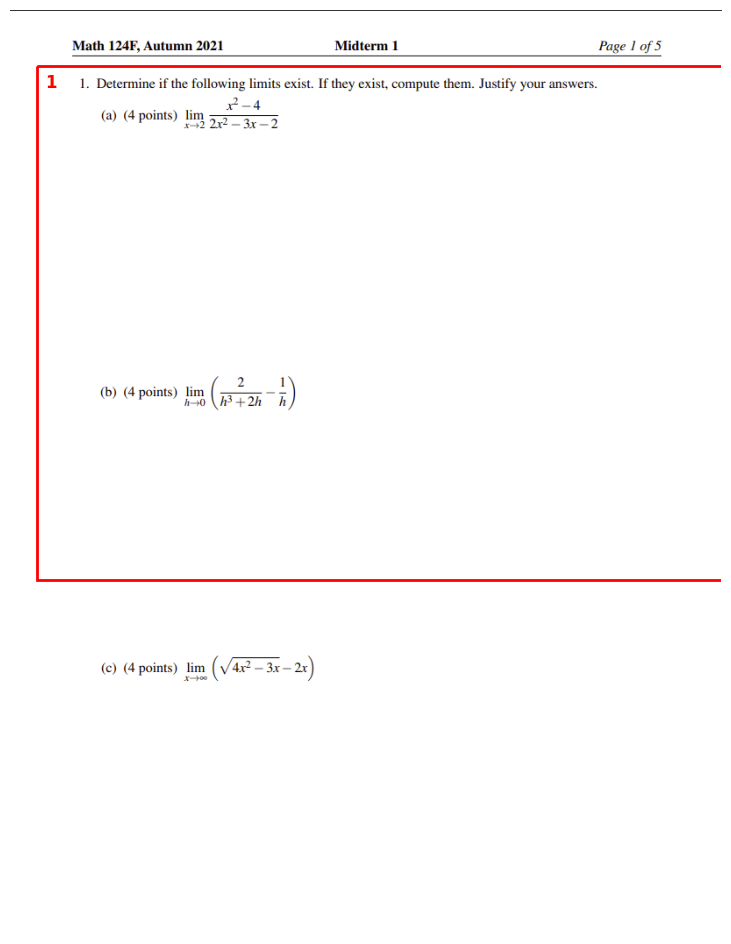

In [12]:
img_path = "data/test-screenshot.png"
pred = {
  "boxes": [
    {
      "x_min": 30,
      "y_min": 64,
      "x_max": 876,
      "y_max": 650
    }
  ]
}

# Reload original image (without overlay)
orig = Image.open(img_path).convert("RGB")

# Plot original with boxes overlay
fig, ax = plt.subplots(figsize=(10, 12))
ax.imshow(orig)

for i, b in enumerate(pred["boxes"], 1):
    rect = plt.Rectangle(
        (b["x_min"], b["y_min"]), 
        b["x_max"] - b["x_min"], 
        b["y_max"] - b["y_min"], 
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(b["x_min"] + 10, b["y_min"] + 25, f"{i}", color="red", fontsize=12, weight="bold")

ax.axis("off")
plt.show()